<a href="https://colab.research.google.com/github/envgp/taking_the_pulse_of_the_planet/blob/main/notebooks/pulse_assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5: Taking the Pulse of Global Groundwater
Sasha Richey (sasha.richey@wsu.ed), Washington State University & Michael Morphew (mmorphew@stanford.edu), Stanford Environmental Geophysics Group

This assignment is due on `2023-2-23`. Please put your answers within this notebook and share the completed notebook with the graders, bsalvado@stanford.edu and mmorphew@stanford.edu, using the Share banner located at the top right corner of this notebook. When sharing your notebook, please change the name of the notebook and add your name and sunetid (e.g., pulse_course_assignment_2_firstname_lastname_sunetid.ipynb)

## INTRODUCTION TO THE ASSIGNMENT
This week we will “operationalize” the water budget at a global level. We will evaluate the trends and variability in the global water budget and leverage additional datasets and model output to better understand the drivers of observed change from both natural and anthropogenic causes. We will focus explicitly on the role of groundwater in global water budget dynamics. Students will select an area of interest to both better understand the regional water budget and to consider the strengths and limitations of remotely sensed observations at large spatial scales. 
## DATA SETS
Data sets used in this assignment are: 1) total water storage change; 2) model output of SWE, soil moisture, canopy water; 3) population density; 4) irrigation density. 

**Resolution**

All datasets have a spatial resolution of 1 degree latitude by 1 degree longitude. All datasets exception irrigation and population density have monthly sampling from 2003-2016. Irrigation and population density are "snapshots" from 2010.

**Units:**

Total Water Storage Change: $[cm]$ (of water)

Model outputs of SWE, soil moisture, and canopy water: $[mm]$

Population density: estimated number of persons per square kilometer

Irrigation density: a number corresponding to land use type: 0=non-cropland, 1=major irrigation, 2=minor irrigation, 3 or higher=rainfed

We will also reference our temperature and precipitation dataset analysis from assignment 2.

Later on, we will need to combine the model outputs with total change in water storage. As we know: 1 cm = 10 mm. So we must divide our model outputs by 10 (or multiply our total water storage change by 10) before doing any combinations.


## TOOLBOX

All the Python packages you will use in this assignment are in the toolbox for the course. **The toolbox has been updated since you last used it.** Some code required for particular problems are provided as needed.

(https://github.com/envgp/taking_the_pulse_of_the_planet/blob/main/notebooks/pulse_toolbox.ipynb)

This assignment references some of the work you did in assignment 2. You may want to open up assignment 2 for reference as you work on this assignment. You will be making more trend maps and performing data extractions like in assignment 2. Please reference your assignment 2 code and the toolbox, and ask a TA if you get stuck. There are no questions which will require completely original coding.

## THE LEARNING GOALS FOR THE WEEK

(where the course learning goals are in plain text, and the focus this week is in italics)

● learn about the ways in which climate change and human activity are impacting planet Earth, *with a focus this week on the global water budget and groundwater.*

● become familiar with the wide range of sensors available to study various components of the Earth system. These include sensors on satellites, aircraft, ground-based platforms, and deployed above or beneath the surface on land or water. *This week we will work with data acquired using satellite systems.* 

● become familiar with the basic physical principles (resolution, sampling, processing workflows, etc.) common to all sensors, *working this week with data sets all of which differ in terms of resolution, sampling, and processing workflows.*

● work with various sources of data, learning how to access, analyze, synthesize, and describe the data to quantify trends; think critically and creatively about how to project these trends into the future. *This week we will consider trends in the data that reveal periods of hydrologic extremes, evaluate the dominant drivers of observed data, compare the data in different geographic regions, and determine causal links between various data sets.*

● describe the complex interactions between human activity and various components of the Earth system. This week we begin by looking at global water budget dynamics to consider how humans add an additional layer of change on top of natural processes, both for the total water budget and groundwater. *In this assignment we will consider how the drivers of observed change may impact the future.*

● become motivated to think about new sensors and new ways of using sensor data to study the planet. This is always the last question in each assignment.

## Download required data and install Packages

In [ ]:
!pip install xarray numpy pandas geopandas cartopy==0.19.0.post1 rioxarray ipywidgets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip uninstall -y shapely

Found existing installation: Shapely 1.8.5.post1
Uninstalling Shapely-1.8.5.post1:
  Successfully uninstalled Shapely-1.8.5.post1


In [ ]:
!pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached shapely-2.0.1.tar.gz (275 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/10/a7/de139da3ce303101c357a9ba801328cba85cf6ace157da31a4007bca85e4/shapely-2.0.1.tar.gz#sha256=66a6b1a3e72ece97fc85536a281476f9b7794de2e646ca8a4517e2e3c1446893 (from https://pypi.org/simple/shapely/) (requires-python:>=3.7): Requested unknown from https://files.pythonhosted.org/packages/10/a7/de139da3ce303101c357a9ba801328cba85cf6ace157da31a4007bca85e4/shapely-2.0.1.tar.gz#sha256=66a6b1a3e72ece97fc85536a281476f9b7794de2e646ca8a4517e2e3c1446893 has inconsistent name: filename has 'shapely', but metadata has 'unknown'
  Using cached shapely-2.0.0.tar.gz (274 kB)
  Installing build dependencies ... done
  Getting requireme

In [ ]:
!git clone https://premonition.stanford.edu/mmorphew/taking-the-pulse-global-data.git

fatal: destination path 'taking-the-pulse-global-data' already exists and is not an empty directory.


In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cf
import datetime
import rioxarray
from shapely.geometry import mapping
matplotlib.rcParams['font.size'] = 14
from ipywidgets import widgets, interact

# Part 1: GRACE Total Water Storage Anomalies

The Gravity Recovery and Climate Experiment (GRACE) satellite mission is a joint mission between the German Space Agency and the U.S. National Aeronautics and Space Agency (NASA). Originally launched to better understand Earth’s gravity field, GRACE has since been used to study a myriad of additional Earth system variables including oceanic currents, sea level rise, and, as you will study in this assignment, groundwater. Gravity anomalies are converted into water mass anomalies to study the hydrologic cycle. GRACE applications to the hydrologic cycle are based on the simple water budget, which uses the conservation of mass principle to evaluate changes in total water storage as the sum of changes in the component parts of the water budget. GRACE provides an integrated measure of the total vertical water column over large areas, but the GRACE observations cannot directly differentiate between mass changes in any particular variable. 

The GRACE-based water budget is calculated either based on changes in total water storage, S, as the sum of changes in fluxes (Equation 1) or based on anomalies in S as the sum of anomalies in stocks (Equation 2). GRACE is a relative gravimeter; therefore it can only observe relative changes in gravity between two time periods or locations and does not observe the total magnitude of the gravity field.

### Equation 1
$\frac{dS}{dt}=P-ET-Q+\frac{dGW}{dt}$
	
$\frac{d}{dt}$ = change in a variable over time $[\frac{1}{T}]$	

$S$ = total water storage $[L]$	

$P$ = precipitation $[\frac{L}{T}]$	

$ET$ = evapotranspiration $[\frac{L}{T}]$	

$Q$ = streamflow $[\frac{L}{T}]$	

$\frac{dGW}{dt}= GW_{in}- GW_{out}$ = change in groundwater flow [L/T]	

### Equation 2
$∆S=∆SW+∆SWE+∆SM+∆GW$

$∆$ = anomaly in a variable 	

$S$ = total water storage [L]	

$∆SW$ = surface water anomaly [L]	

$∆SWE$= snow water equivalent anomaly [L]	

$∆SM$= soil moisture anomaly [L]	

$∆GW$ = groundwater anomaly	


## Q1-a: Global Trend Map for Total Water Storage Anomaly
Produce a globally gridded map of the trend in total water storage anomalies for the recent period (2003-2015). Begin by calculating the mean in each grid cell and subtract that mean from each month’s value per grid cell to produce anomalies. Then, calculate the trend in each grid cell using the anomalies. Comment on similarities and differences between this map and the trend maps for precipitation you did in assignment 2. 

Let's walk through calculating and subtracting out the mean first, then try making the map yourself.

In [ ]:
total_water_storage_data = xr.load_dataset('taking-the-pulse-global-data/twsa.nc')
total_water_storage_data = total_water_storage_data.transpose("time", "y", "x")
total_water_storage_data

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, time: 168)
Coordinates:
  * y        (y) int64 -90 -89 -88 -87 -86 -85 -84 -83 ... 83 84 85 86 87 88 89
  * x        (x) int64 -180 -179 -178 -177 -176 -175 ... 174 175 176 177 178 179
  * time     (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2016-12-01
Data variables:
    TWSA     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

In [ ]:
total_water_storage_mean = total_water_storage_data.mean(['time'])
### this is taking an average in time, the result will be a single "map" of the mean for each data cell.

In [ ]:
total_water_storage_anomaly = total_water_storage_data.copy(deep=True)
for i in range(len(total_water_storage_data.time)):
  total_water_storage_anomaly['TWSA'][i,:,:] = total_water_storage_anomaly['TWSA'][i,:,:] - total_water_storage_mean['TWSA']
### now we just step through time and subtract out the mean for each time step to create an anomaly

**Now that we have the anomaly, we just need to calculate the trend map and plot it.**

In [ ]:
### your code here

##Q1-b: Basin Averages for GRACE

We have provided a map of the major groundwater basins in the world. The code below gives you access to the shape information for these basins so that you can extract basin-wide information, similar to how you did so at the country-scale in assignment 2. Select one basin to be your region of interest for this assignment. **Whenever this assignment asks you to make regional maps or regional calculations, we are referring to this basin that you have selected**. 


For your selected basin, calculate a basin-average of the GRACE TWS anomalies. Plot the time series and calculate the 1D trend (not a trend map!) of the basin-average and comment on what you see. 


A cleaner image of the basin map produced in the code below may be found here, as an aid in selecting your basin:
https://www.cbc.ca/polopoly_fs/1.3117673.1434572717!/fileImage/httpImage/aquifer-depletion.jpg

**Be patient with the link, it will take a second to load.**

In [ ]:
world_aquifers = gpd.read_file('taking-the-pulse-global-data/world_aquifer_systems_nocoast/world_aquifer_systems_nocoast.shp')
world_aquifers['Aquifer_sy']

0     Guarani Aquifer System (Parana&Choco Parana Ba...
1                                        Maranhao Basin
2              Atlantic and Gulf Coastal Plain Aquifers
3                                                   NaN
4                California Cenral Vally Aquifer System
5                                         Canning Basin
6                                  Great Artesian Basin
7     Nubian Aqufer System (Nubian Sandstone and Pos...
8                           Sahara Septentrional (SASS)
9                                    Murzuk-Djado Basin
10                            Taoudeni-Tanezrouft Basin
11                          Bassin Sénégalo-Mauritanien
12                    Iullemeden-Irhazer Aquifer System
13                                  Bassin du lac Tchad
14                                                  NaN
15                                    Ogaden-juba Basin
16                                      Bassin du Congo
17                                              

One practical part of data science is updating any missing parts of the data. Here I have updated the NaN entries with their proper basin name.

In [ ]:
world_aquifers['Aquifer_sy']
world_aquifers.at[3,'Aquifer_sy'] = 'Cambro-Ordovician Aquifer System'
world_aquifers.at[35, 'Aquifer_sy'] = 'Northern Great Plains Aquifer'
world_aquifers.at[17, 'Aquifer_sy'] = 'Upper Kalahari-Cuvelai-Upper Zambezi Basin'
world_aquifers.at[18, 'Aquifer_sy'] = 'Lower Kalahri-Stampriest Basin'
world_aquifers.at[14, 'Aquifer_sy'] = 'Sudd Basin (Umm Ruwaba Aquifer)'

In [ ]:
world_aquifers['Aquifer_sy']

0     Guarani Aquifer System (Parana&Choco Parana Ba...
1                                        Maranhao Basin
2              Atlantic and Gulf Coastal Plain Aquifers
3                      Cambro-Ordovician Aquifer System
4                California Cenral Vally Aquifer System
5                                         Canning Basin
6                                  Great Artesian Basin
7     Nubian Aqufer System (Nubian Sandstone and Pos...
8                           Sahara Septentrional (SASS)
9                                    Murzuk-Djado Basin
10                            Taoudeni-Tanezrouft Basin
11                          Bassin Sénégalo-Mauritanien
12                    Iullemeden-Irhazer Aquifer System
13                                  Bassin du lac Tchad
14                      Sudd Basin (Umm Ruwaba Aquifer)
15                                    Ogaden-juba Basin
16                                      Bassin du Congo
17           Upper Kalahari-Cuvelai-Upper Zambez

In [ ]:
world_aquifers['coords'] = world_aquifers['geometry'].apply(lambda x: x.representative_point().coords[:])
world_aquifers['coords'] = [coords[0] for coords in world_aquifers['coords']]

(-90.0, 90.0)

/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:556: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
<__array_function__ internals>:5: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4817: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the 

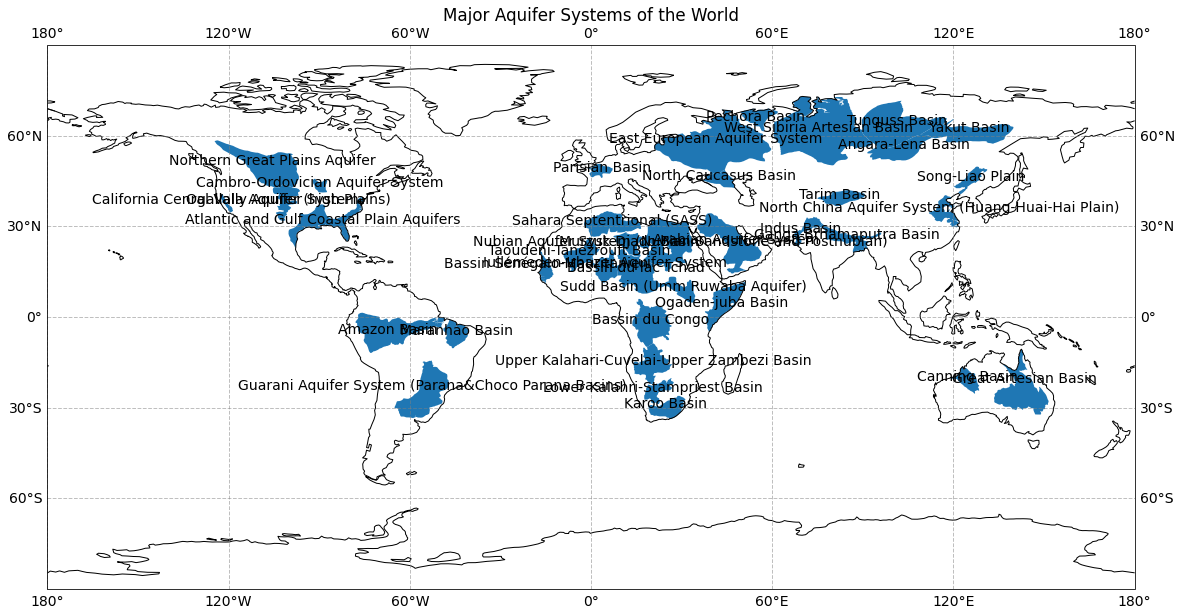

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE)

out = world_aquifers.plot(ax=ax, label=world_aquifers['Aquifer_sy'])
for idx, row in world_aquifers.iterrows():
    plt.annotate(s=row['Aquifer_sy'], xy=row['coords'],
                 horizontalalignment='center')
#cb = plt.colorbar(out, fraction=0.04, orientation='horizontal')
#cb.set_label("Rate of monthly temperature change (K/month)")
ax.set_aspect(1)
#ax.set_facecolor('lightblue')
ax.set_title("Major Aquifer Systems of the World")

gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=1, 
    color='gray', 
    alpha=0.5, 
    linestyle='--'
)
ax.set_xlim(-180, 180)
ax.set_ylim(-90,90)

**Below, edit the code with the name of the basin you wish to study in more detail.**

In [ ]:
my_aquifer_name = 'Tunguss Basin'
my_aquifer = world_aquifers[world_aquifers['Aquifer_sy']==my_aquifer_name]
my_aquifer

,OBJECTID,AREA,PERIMETER,WROB0_CONT,WROB0_CO_1,HYGEO,Aquifer_sy,Shape_Leng,Shape_Area,geometry,coords
23,3676,1.047059e+14,2.062106e+08,158,0,26,Tunguss Basin,65.460579,223.19183,"POLYGON ((91.43304 67.57074, 91.84391 67.90138...","(101.29703529854936, 63.884117145500056)"


**Now calculate a 1D temporal trend for your basin and plot it. (Check the toolbox, it's not as big of an ask as it sounds!)**

In [ ]:
### your code here

# Part 2: GRACE-derived Groundwater Anomalies

GRACE has revolutionized the study of large-scale groundwater dynamics by allowing for an integrated picture of groundwater changes that do not rely on sparse in situ observation networks. However, as with any tool, the use of GRACE to study groundwater needs to be carefully considered. GRACE-derived groundwater anomalies can be calculated as a residual by rearranging Equation 2 above to solve for groundwater. GRACE anomalies are used for ∆S and additional data sources are used for the remaining components such as model output, in situ observations or remotely sensed observations as available. In this assignment, we’ll use model output and you’ll be asked to identify any additional datasets as needed. 


 


##Q 2-a: Global Groundwater Anomalies
The Global Land Data Assimilation System (GLDAS) is a NASA modeling framework that utilizes data assimilation to update model states based on available observations. GLDAS runs multiple different land surface models within this framework, keeping the forcing data and assimilation methods consistent across the models such that an ensemble mean and standard deviation can be calculated based on the results of multiple models run together. Calculate global groundwater anomalies using the GLDAS output that has been provided to you for soil moisture, snow water equivalent and canopy water as well as the GRACE anomalies by rearranging Equation 2 to solve for groundwater anomalies. Document if there are any additional large water features in your study area (such as lakes, reservoirs, or glaciers) that are not accounted for in the GLDAS output and comment on how these features will impact your results.


Recall that model outputs are in mm and total water storage anomaly is in cm.

In [ ]:
gldas_snow_water_equivalent = xr.load_dataset('taking-the-pulse-global-data/SWE.nc')
gldas_snow_water_equivalent = gldas_snow_water_equivalent.transpose("time", "y", "x")
gldas_canopy_water = xr.load_dataset('taking-the-pulse-global-data/can.nc')
gldas_canopy_water = gldas_canopy_water.transpose("time", "y", "x")
gldas_soil_moisture = xr.load_dataset('taking-the-pulse-global-data/sm.nc')
gldas_soil_moisture = gldas_soil_moisture.transpose("time", "y", "x")

In [ ]:
gldas_snow_water_equivalent

<xarray.Dataset>
Dimensions:              (y: 180, x: 360, time: 168)
Coordinates:
  * y                    (y) int64 -90 -89 -88 -87 -86 -85 ... 84 85 86 87 88 89
  * x                    (x) int64 -180 -179 -178 -177 -176 ... 176 177 178 179
  * time                 (time) datetime64[ns] 2003-01-01 ... 2016-12-01
Data variables:
    SnowWaterEquivalent  (time, y, x) float64 nan nan nan nan ... nan nan nan

In [ ]:
gldas_canopy_water

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, time: 168)
Coordinates:
  * y        (y) int64 -90 -89 -88 -87 -86 -85 -84 -83 ... 83 84 85 86 87 88 89
  * x        (x) int64 -180 -179 -178 -177 -176 -175 ... 174 175 176 177 178 179
  * time     (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2016-12-01
Data variables:
    Canopy   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

In [ ]:
gldas_soil_moisture

<xarray.Dataset>
Dimensions:       (y: 180, x: 360, time: 168)
Coordinates:
  * y             (y) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * x             (x) int64 -180 -179 -178 -177 -176 ... 175 176 177 178 179
  * time          (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2016-12-01
Data variables:
    SoilMoisture  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [ ]:
### your code here

## Q 2-b: Basin-averaged time series

Produce a basin-averaged time series and trend of the groundwater anomalies for your focus region. Compare and contrast the groundwater versus total water storage anomalies trend and time series. 

Also plot the individual components for your region (soil moisture, canopy water, snow water equivalent). Of the water budget components on the right hand side of Equation 2, which component(s) is dominating the total GRACE signal?

In [ ]:
### your code here

## Q 2-c: Groundwater in your study area
Conduct a short search about groundwater in your study area. Describe the large aquifer system you chose: briefly describe the system (3-4 sentences) and comment on how well the GRACE-derived groundwater anomalies are representing your type of aquifer.

**Gold star bonus: if you can find data describing water sources that may distort the water budget from the GRACE and GLDAS data/outputs that we are already using, try incorporating it into your results. You can upload files manually in Google Colab using the folder icon on the lefthand side of the screen to navigate to the files menu, then hit the upload button.**


**Your answer here**

## Q 2-d: Comparing Groundwater with Population and Irrigation Density
Plot the population density and irrigation extent maps, zoomed into your focus region. Based on these maps, and additional information as needed, what do you think is driving the total water storage and groundwater patterns observed in the previous two questions? What implications exist for the future state of groundwater and total water availability based on your attribution of change? 

In [ ]:
### your code here
population_density = xr.load_dataset('taking-the-pulse-global-data/population_density.nc')
population_density = population_density.sel(time='2010-01-01', method='nearest')
irrigation_density = xr.load_dataset('taking-the-pulse-global-data/irrigation_density.nc')
irrigation_density = irrigation_density.isel(time=0)

In [ ]:
### you may find the following color map useful for plotting the irrigation dataset
### rather than cmap='RdBu', use cmap=discrete_cmap in your plotting code
discrete_cmap = colors.ListedColormap(['white','b','y','g','r', 'pink'])

In [ ]:
population_density

<xarray.Dataset>
Dimensions:             (y: 180, x: 360)
Coordinates:
    time                datetime64[ns] 2010-01-01
  * y                   (y) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * x                   (x) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    population_density  (y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    transform:               [   1.    0. -180.    0.   -1.   90.]
    crs:                     +init=epsg:4326
    res:                     [1. 1.]
    is_tiled:                1
    nodatavals:              -32768.0
    scales:                  1.0
    offsets:                 0.0
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [ ]:
irrigation_density

<xarray.Dataset>
Dimensions:    (y: 180, x: 360)
Coordinates:
    time       datetime64[ns] 2010-01-01
  * y          (y) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * x          (x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    landcover  (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    transform:               [   1.    0. -180.    0.   -1.   90.]
    crs:                     +init=epsg:4326
    res:                     [1. 1.]
    is_tiled:                1
    nodatavals:              -32768.0
    scales:                  1.0
    offsets:                 0.0
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

# Q3: Taking the Pulse in the Future

In this assignment, we worked with what we have in terms of sensors and data analysis workflows. If you were given $1 million to develop a new form of sensor or new form of data analysis, what would you do? This can be research, field work, fabrication of sensors, etc. Think about what you would measure, at what spatial and temporal scale and resolution. Over to you to design the next generation of sensors for taking the pulse of our groundwater systems.